In [7]:
##Loading the Dataset 
import pandas as pd

df = pd.read_csv("C://Users//admin//Desktop//Fake Job Prediction//fake_job_postings.csv")
df.shape  # (rows, columns)

(17880, 18)

In [8]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [9]:
##Clean and Normalize the Text
import re, html

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = html.unescape(text)
    text = re.sub(r"<[^>]+>", " ", text)                    # Remove HTML tags
    text = re.sub(r"(https?://\S+|www\.\S+)", " ", text)     # URLs
    text = re.sub(r"\S+@\S+", " ", text)                    # Emails
    text = re.sub(r"\b\d{10,}\b", " ", text)                # Phone-like long numbers
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)             # Keep only alphanum
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text


In [10]:
##joining important fields into a new text_clean column

def join_fields(row):
    fields = ["title", "company_profile", "description", "requirements", "benefits"]
    text = " ".join(str(row.get(f, "")) for f in fields)
    return clean_text(text)

df["text_clean"] = df.apply(join_fields, axis=1)


In [11]:
df[["title", "description", "text_clean"]].sample(5)

,title,description,text_clean
15850,Chief Marketing Officer,ABOUT THE COMPANYFusemachines combines the pow...,chief marketing officer fusemachines combines ...
7486,Specialist Curriculum Associate,We take great pride in ensuring that the mater...,specialist curriculum associate shape the futu...
4199,Shyp Hero Courier - Miami,Trustworthy. Efficient. Street-Smart.Are you a...,shyp hero courier miami nan trustworthy effici...
1394,TLL (Chinese Lab) - Specialist Teaching Associate,Future China for Future Leaders.Chinese Lab is...,tll chinese lab specialist teaching associate ...
16507,Web Designer & Front End Developer,As a Web Designer and Front End Developer you'...,web designer front end developer we seek talen...


In [12]:
df["len_text"] = df["text_clean"].str.len()
df["num_urls"] = df["text_clean"].str.count("http|www")
df["num_emails"] = df["text_clean"].str.count("@")
df["kw_fee"] = df["text_clean"].str.contains("fee").astype(int)
df["kw_urgent"] = df["text_clean"].str.contains("urgent|immediate").astype(int)

df[["len_text", "num_urls", "num_emails", "kw_fee", "kw_urgent"]].describe()


,len_text,num_urls,num_emails,kw_fee,kw_urgent
count,17880.000000,17880.000000,17880.0,17880.000000,17880.000000
mean,2593.073770,0.013814,0.0,0.208557,0.082942
std,1419.053797,0.134115,0.0,0.406288,0.275802
min,30.000000,0.000000,0.0,0.000000,0.000000
25%,1554.000000,0.000000,0.0,0.000000,0.000000
50%,2456.000000,0.000000,0.0,0.000000,0.000000
75%,3386.000000,0.000000,0.0,0.000000,0.000000
max,14575.000000,5.000000,0.0,1.000000,1.000000


In [13]:
#Drop Duplicates
df["text_hash"] = df["text_clean"].apply(lambda x: hash(x))
before = len(df)
df = df.drop_duplicates(subset="text_hash").reset_index(drop=True)
after = len(df)
print(f"Removed {before - after} duplicates. Remaining: {after}")


Removed 2130 duplicates. Remaining: 15750


In [14]:
##Checking Class Imbalance 
df["fraudulent"].value_counts(normalize=True).round(3)


fraudulent
0    0.955
1    0.045
Name: proportion, dtype: float64

In [15]:
##split the data into train and test sets
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, test_size=0.2, stratify=df["fraudulent"], random_state=42)
val, test = train_test_split(temp, test_size=0.5, stratify=temp["fraudulent"], random_state=42)

print("Train:", len(train), "Val:", len(val), "Test:", len(test))
print("Train fake ratio:", round(train["fraudulent"].mean(), 3))


Train: 12600 Val: 1575 Test: 1575
Train fake ratio: 0.045


In [18]:
train.to_csv("C:/Users/admin/Desktop/Fake Job Prediction/Data/processed/train.csv", index=False)
val.to_csv("C:/Users/admin/Desktop/Fake Job Prediction/Data/processed/val.csv", index=False)
test.to_csv("C:/Users/admin/Desktop/Fake Job Prediction/Data/processed/test.csv", index=False)



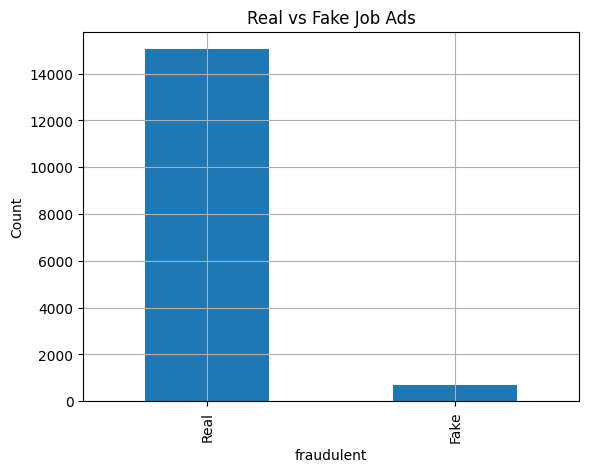

In [19]:
##Visualizing Class Imbalance
import matplotlib.pyplot as plt

df["fraudulent"].value_counts().plot(kind="bar")
plt.title("Real vs Fake Job Ads")
plt.xticks(ticks=[0, 1], labels=["Real", "Fake"])
plt.ylabel("Count")
plt.grid(True)
plt.show()
